https://en.wikipedia.org/wiki/AdaBoost


# AdaBoost

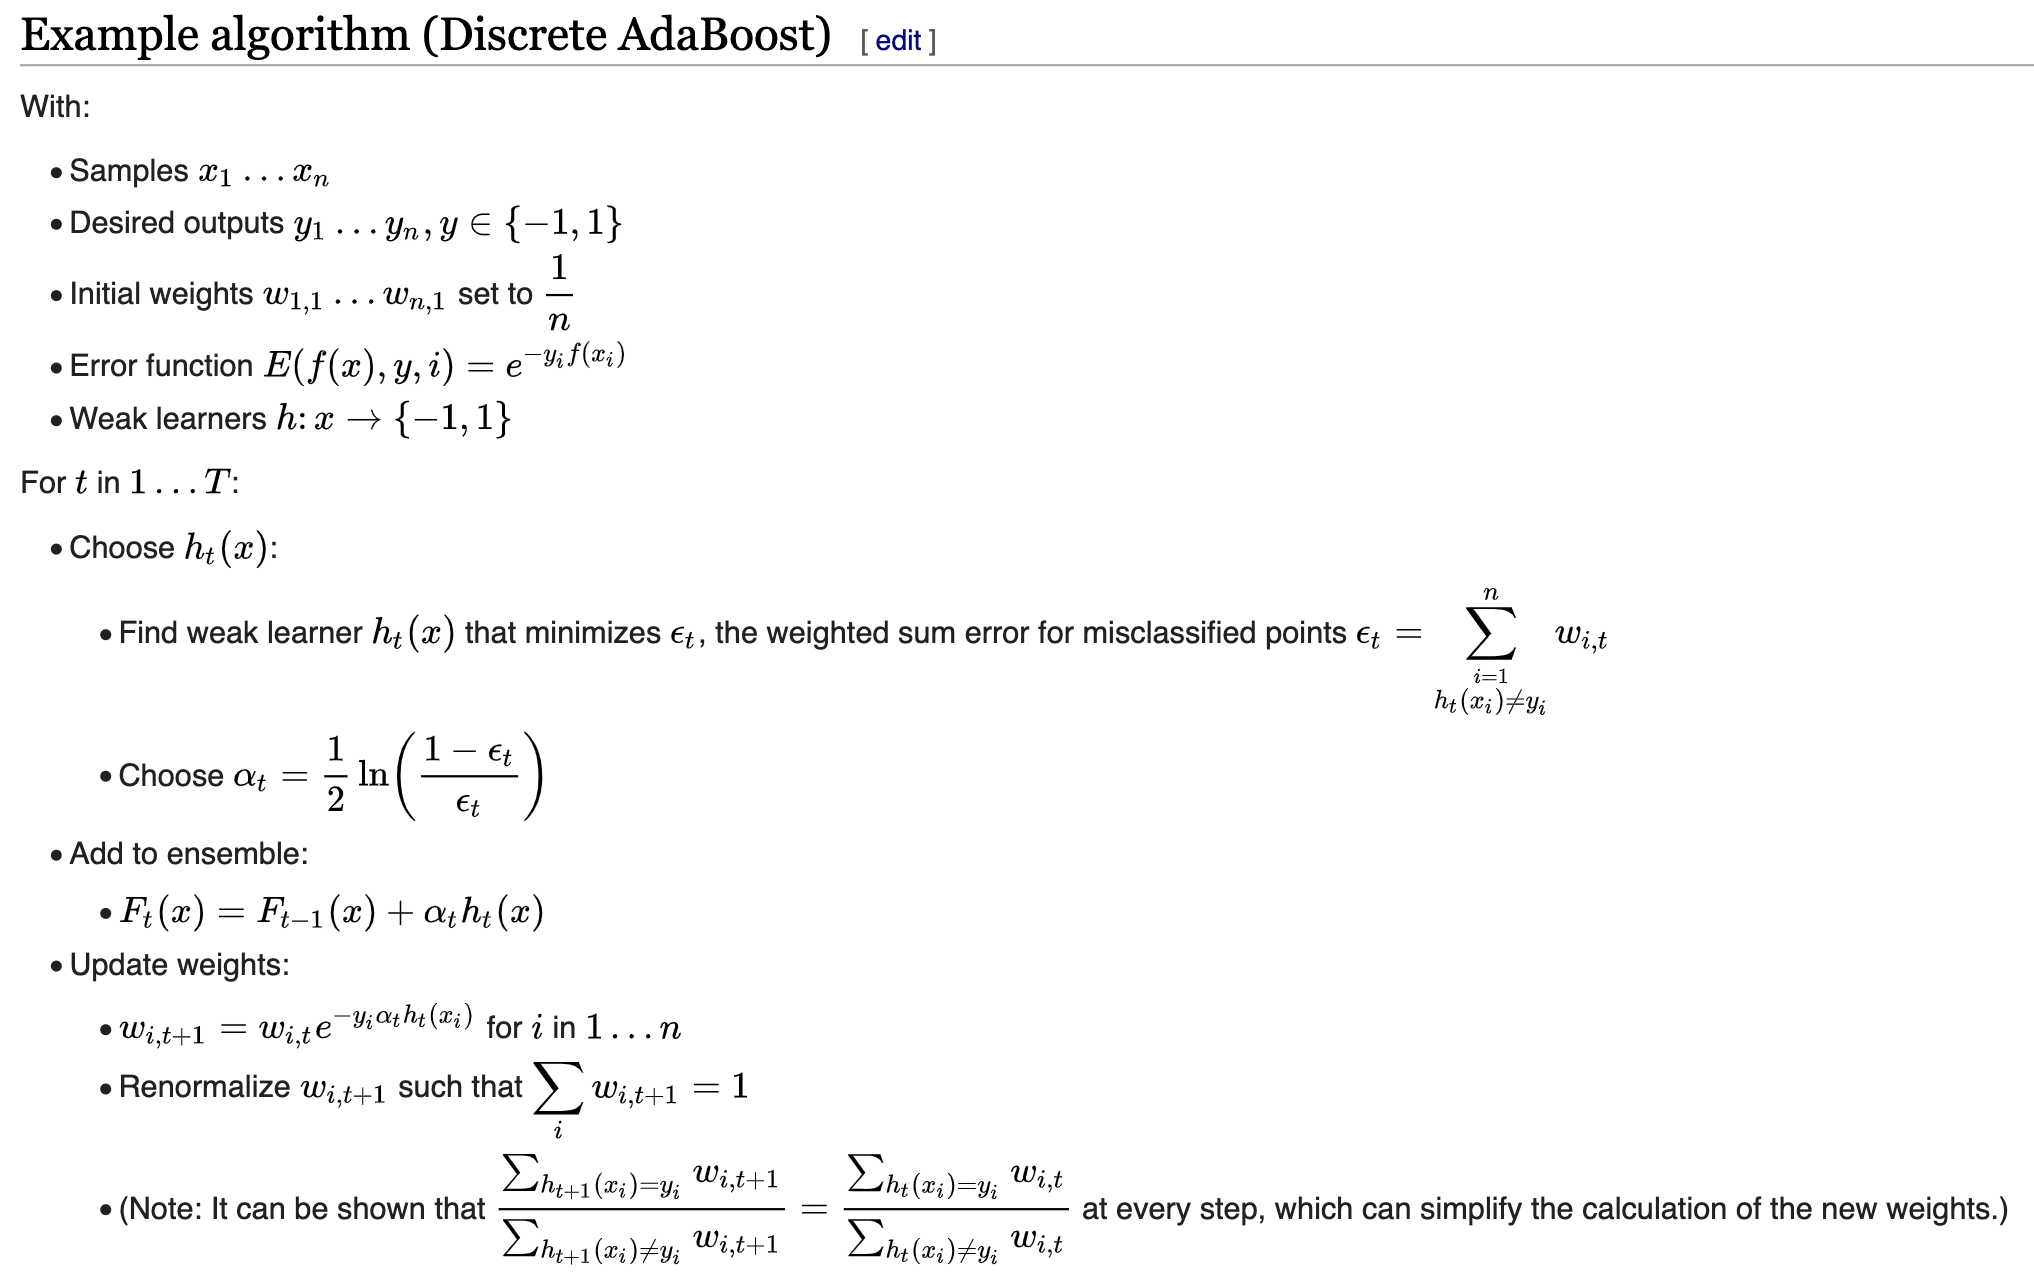

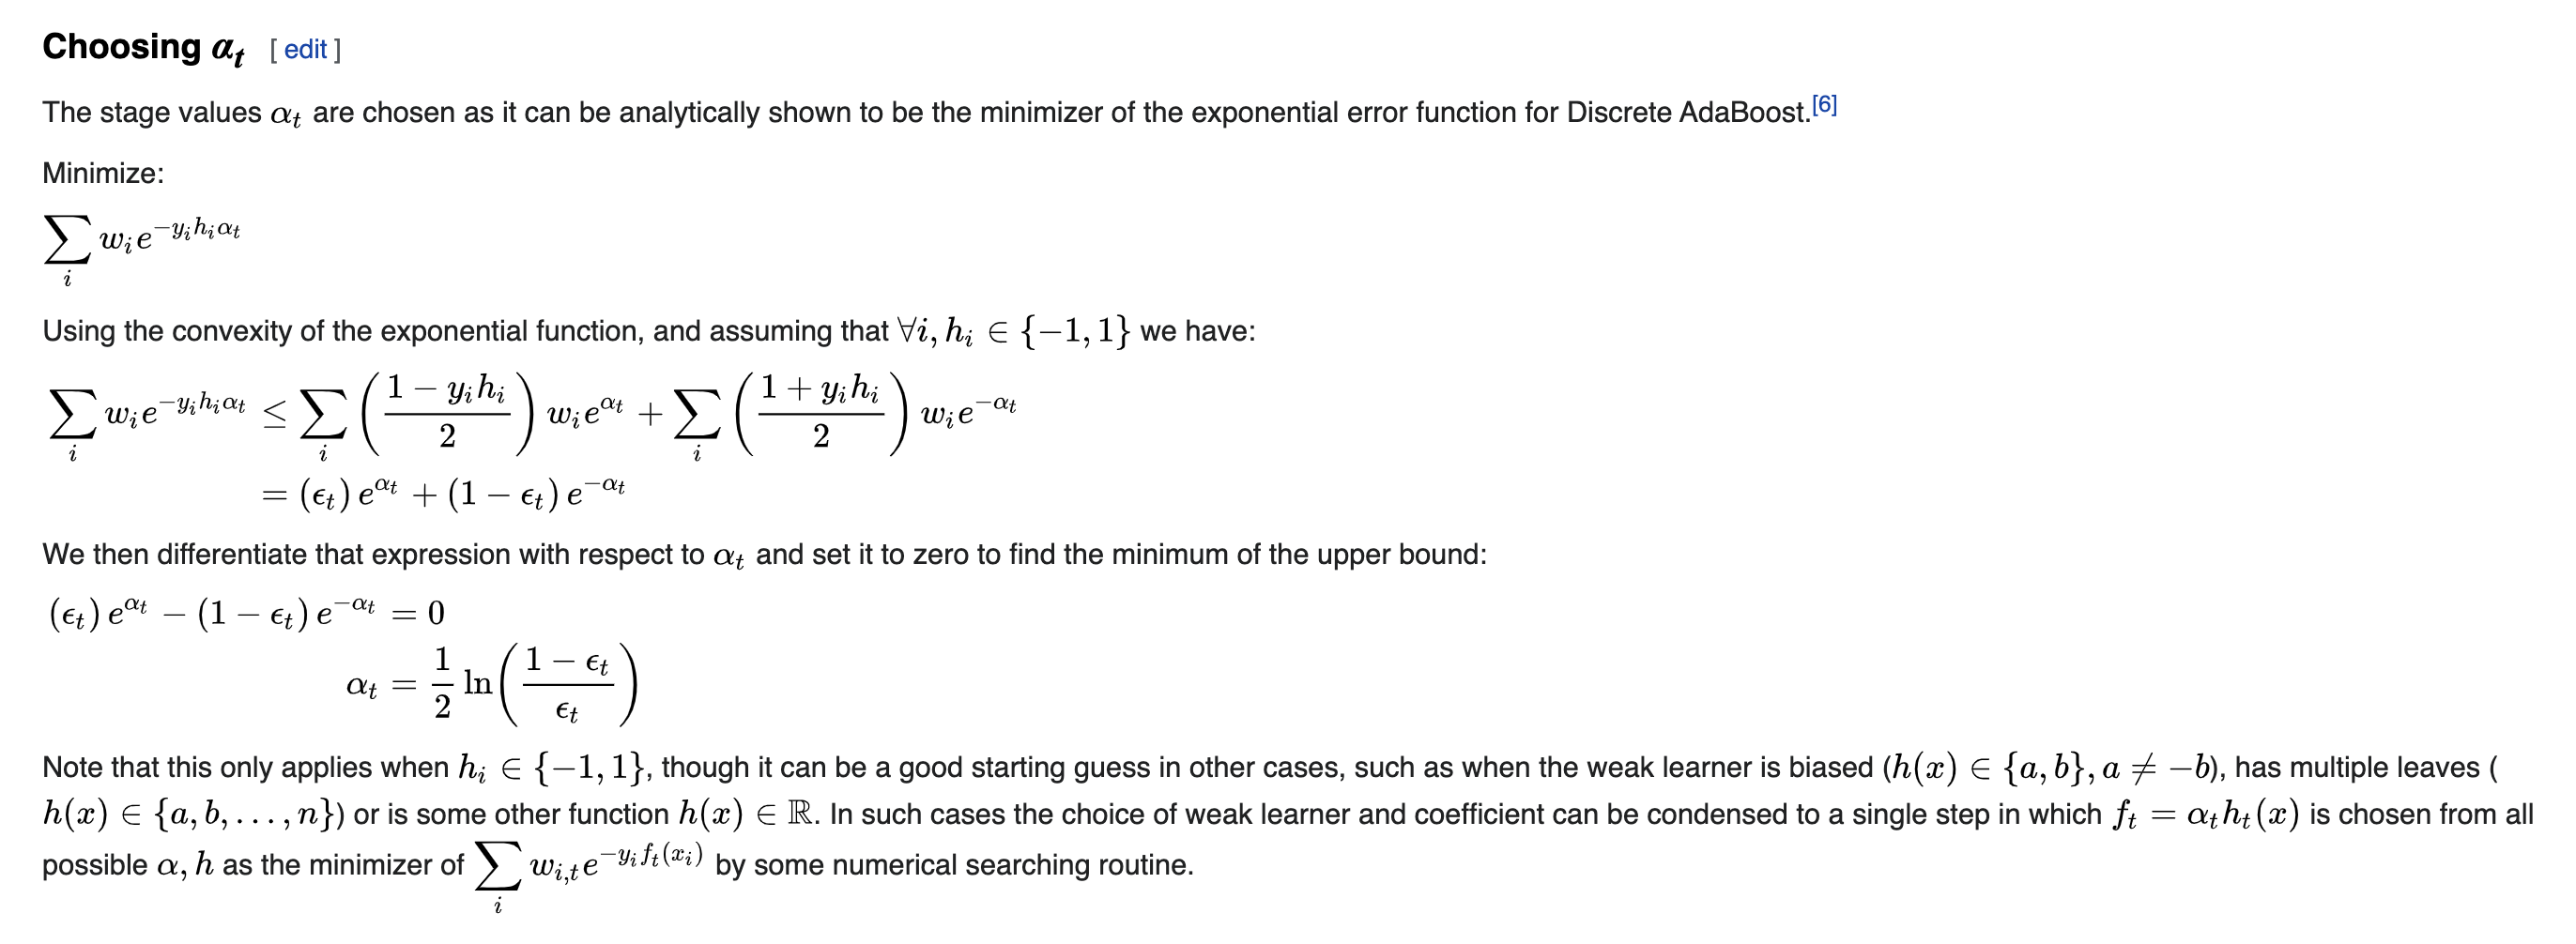

In [1]:
import numpy as np
from numpy import log
from numpy import exp

In [2]:
# Weak Learner
class Tree_Stump:

    def __init__(self):
        self.flip_decision = 0    # flip the decision rule if it is equal to 1
        self.split_feature = None # the feature name of the split
        self.split_value = None # the feature value of the split
        self.alpha = None   # weight of this classifier

    def _predict(self, X): # make prediction based on split feature and split value
        n_row, _ = X.shape
        preds = np.ones(n_row)
        if self.flip_decision == 0: 
            preds[X[:, self.split_feature] < self.split_value] = -1
        else: # flip decision
            preds[X[:, self.split_feature] > self.split_value] = -1
        return preds

In [3]:
class AdaBoost_Classifier:

    def __init__(self, n_estimators=100): # n_estimators: how many weak learners to ensemble
        self.n_estimators = n_estimators
        self.estimators = [] # empty list to load/ensemble the learners

    def fit(self, X, y):
        pass

    def predict(self, X):
        preds_raw = [
            estimator.alpha * estimator._predict(X)
            for estimator in self.estimators
        ] # Go through every learner and add the predictions
        y_preds = np.sign(np.sum(preds_raw, axis=0)) # Take the sign of the sum of raw predictions
        y_preds[y_preds == -1] = 0 # convert back to normal notation of binary classification
        return y_preds

In [4]:
def fit(self, X, y):
    y = np.where(y == 0, -1, 1) # Convert to AdaBoost understanding of positive and negative classes

    n_row, n_col = X.shape

    weights = np.ones(n_row) / n_row

    # Iterate through classifiers
    for _ in range(self.n_estimators): 
        estimator = Tree_Stump() # every weak learner
        loss_best = np.inf # initialize the loss

        # greedy search to find best feature and its value
        for feature_col in range(n_col):
            feature_vals = X[:, feature_col]
            vals = np.unique(feature_vals)

            for val in vals:

                flip = 0
                preds = np.ones(n_row)
                preds[feature_vals < val] = -1

                misclassified = weights[y != preds]
                loss = np.sum(misclassified)

                if loss > 0.5:
                    flip = 1
                    loss = 1 - loss

                if loss < loss_best:
                    estimator.flip_decision = flip
                    estimator.split_feature = feature_col
                    estimator.split_value = val
                    loss_best = loss

        #print(loss_best)

        eps = 1e-5 # avoid devision by zero error
        estimator.alpha = 0.5 * log((1.0 - loss_best) / (loss_best + eps))

        preds = estimator._predict(X)

        weights = weights * exp(-estimator.alpha * y * preds)
        weights = weights / np.sum(weights) # normalize the weights 
        self.estimators.append(estimator)

In [5]:
AdaBoost_Classifier.fit = fit

In [6]:
if __name__ == "__main__":
    import pandas as pd
    df = pd.read_csv('/Users/ziyezhang/Documents/GitHub/Optimization/Decision-Tree-from-scratch/titanic.csv',
                     usecols=[
                         'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
                         'Fare', 'Embarked'
                     ])
    df.isna().sum()

    y = df['Survived']
    X = df.drop('Survived', axis=1)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=42)

    ### Do some imputation since algorithms cannot handle missing values

    from sklearn.impute import SimpleImputer

    imp = SimpleImputer(strategy='mean')
    X_train[['Age']] = imp.fit_transform(X_train[['Age']])

    imp2 = SimpleImputer(strategy='most_frequent')
    X_train[['Embarked']] = imp2.fit_transform(X_train[['Embarked']])

    # Prepare train and test data
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer

    ohe = OneHotEncoder()
    ct = make_column_transformer((ohe, ['Sex', 'Embarked']),
                                 remainder='passthrough')
    X_train_vect = ct.fit_transform(X_train)
    y_train = y_train.values
    X_test[['Age']] = imp.transform(X_test[['Age']])
    X_test[['Embarked']] = imp2.transform(X_test[['Embarked']])
    X_test_vect = ct.transform(X_test)
    y_test = y_test.values
    model = AdaBoost_Classifier(100)
    model.fit(X_train_vect, y_train)

    y_pred = model.predict(X_test_vect)
    accuracy = sum(y_pred == y_test) / len(y_test)
    print("Accuracy:", accuracy)

Accuracy: 0.7947761194029851


In [7]:
if __name__ == "__main__":
    # Imports
    from time import time
    t0 = time()
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=1234)

    model = AdaBoost_Classifier(40)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy(y_test, y_pred)

    print("Accuracy:", acc)

    t1 = time()

    total = t1 - t0
    print(total, 's')

Accuracy: 0.9473684210526315
7.6785149574279785 s


# Appendix:
## Why we need to flip the decision

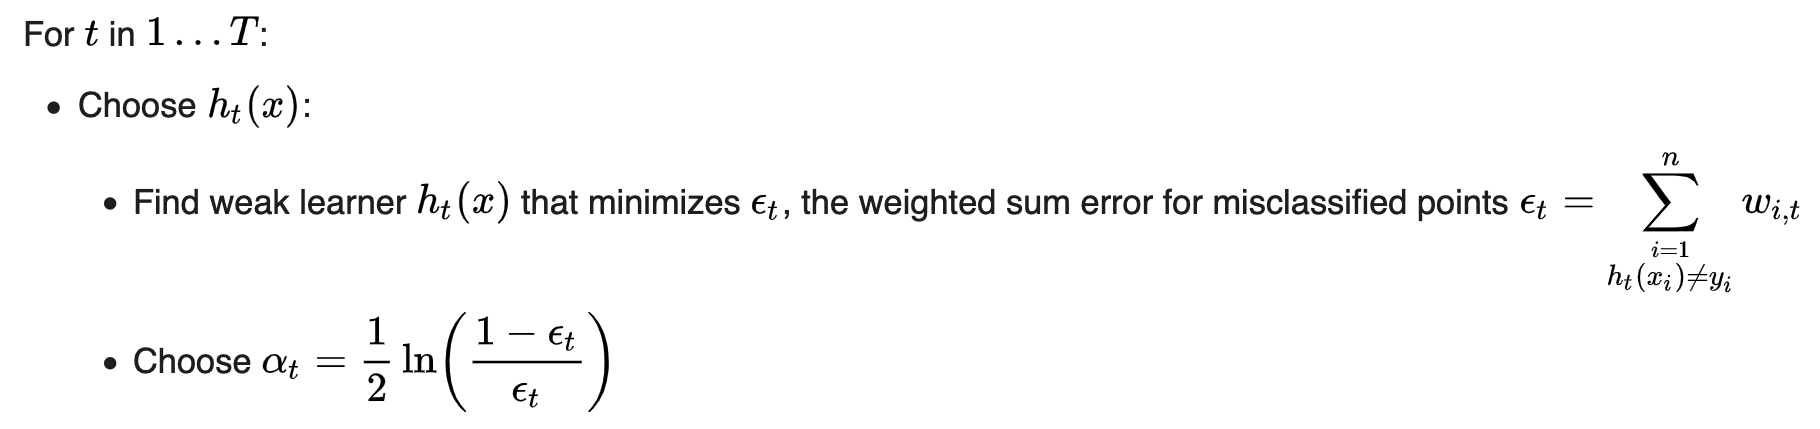

Note $\epsilon$ is the loss of the classifier and ranges between 0 and 1. If it is greater than 0.5, then it is a bad classifier whereas the opposite decision is a good one. 

Our learner would be unstable if some $\alpha_t$ are less than 0 (positive trees and negative trees cancel out each other). See the plot below

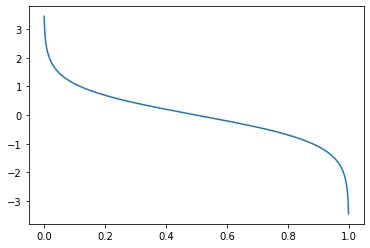

In [8]:
import matplotlib.pyplot as plt
epsilon = np.arange(0.001,1,0.001)
alpha = 0.5*log((1-epsilon)/epsilon)
plt.plot(epsilon,alpha)

So we flip the decision when loss is greater than 0.5 and thus always make the tree positive. And we weight more to the trees having less loss in our ensemble algorithm.

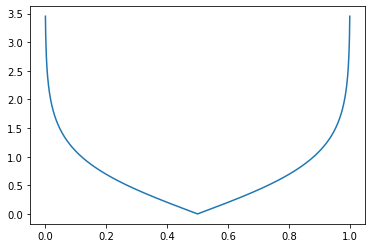

In [9]:
alpha = np.where(alpha<0,-alpha,alpha)
plt.plot(epsilon,alpha)